In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import skimage
import math
from skimage.io import imsave, imread
from skimage.transform import resize
from PIL import Image
from shutil import copyfile
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adadelta, Adam
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16

from keras.layers import BatchNormalization
from keras.optimizers import RMSprop

from keras.utils import np_utils

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.svm import SVC

%matplotlib inline

In [2]:
from preprocess import load_dir, preprocess_and_save_images, divide_to_train_end_test
from custom_metrics import precision, recall, fmeasure

In [3]:
from work_with_keras_nets import shuffle_Xy, create_net_with_name, one_hot, plot_confusion_matrix

In [4]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [5]:
# fix random seed for reproducibility
np.random.seed(42)

In [6]:
def load_dir_with_files_divided_to_5(directory, target_names):
    X_lt = []
    X_rt = []
    X_lb = []
    X_rb = []
    X_ct = []
    
    y_lt = []
    y_rt = []
    y_lb = []
    y_rb = []
    y_ct = []    
    
    for root, dirs, files in os.walk(directory):
        for name in files:
            file_path = os.path.join(root, name)
            target_name_dir_path, corner_name = os.path.split(root)
            _, target_name = os.path.split(target_name_dir_path)
            
            cur_X = imread(file_path)
            
            # сравниваем считанный target_name с названиями из target_names
            cur_y = target_names.index(target_name)
            
            if corner_name == "left_top":
                X_lt.append(cur_X)
                y_lt.append(cur_y)
            if corner_name == "right_top":
                X_rt.append(cur_X)
                y_rt.append(cur_y)
            if corner_name == "left_bottom":
                X_lb.append(cur_X)
                y_lb.append(cur_y)
            if corner_name == "right_bottom":
                X_rb.append(cur_X)
                y_rb.append(cur_y)
            if corner_name == "center":
                X_ct.append(cur_X)
                y_ct.append(cur_y)
                
    return np.array(X_lt), np.array(y_lt), np.array(X_rt), np.array(y_rt), np.array(X_lb), np.array(y_lb), \
np.array(X_rb), np.array(y_rb), np.array(X_ct), np.array(y_ct)
    

In [7]:
%%time
X_lt_FNS128, y_lt_FNS128, X_rt_FNS128, y_rt_FNS128, X_lb_FNS128, y_lb_FNS128, X_rb_FNS128, y_rb_FNS128, X_ct_FNS128, y_ct_FNS128 \
= load_dir_with_files_divided_to_5("D:/svruchtel/PREPROCESSED_DATA/France_New_ByShape_128_3dim",
                                ["A4", "Slip", "Ticket"])

Wall time: 27.3 s


In [53]:
def predict_with_cutted_VGG16_for_dataset(X, y, num_categories):

    X_train, y_train, X_test, y_test = divide_to_train_end_test(X, y, num_categories=3)

    #VGG16 net without last layers
    model_app = VGG16(input_shape=X_train[0].shape, include_top=False)
    model_predict_train = model_app.predict(X_train)
    model_predict_test = model_app.predict(X_test)
    
    return model_predict_train, y_train, model_predict_test, y_test


In [54]:
%%time
X_lt_train, y_lt_train, X_lt_test, y_lt_test = predict_with_cutted_VGG16_for_dataset(X_lt_FNS128, y_lt_FNS128, num_categories=3)

Wall time: 9.33 s


In [55]:
%%time
X_rt_train, y_rt_train, X_rt_test, y_rt_test = predict_with_cutted_VGG16_for_dataset(X_rt_FNS128, y_rt_FNS128, num_categories=3)

Wall time: 9.65 s


In [59]:
%%time
X_lb_train, y_lb_train, X_lb_test, y_lb_test = predict_with_cutted_VGG16_for_dataset(X_lb_FNS128, y_lb_FNS128, num_categories=3)
X_rb_train, y_rb_train, X_rb_test, y_rb_test = predict_with_cutted_VGG16_for_dataset(X_rb_FNS128, y_rb_FNS128, num_categories=3)
X_ct_train, y_ct_train, X_ct_test, y_ct_test = predict_with_cutted_VGG16_for_dataset(X_ct_FNS128, y_ct_FNS128, num_categories=3)

Wall time: 28.4 s


In [43]:
for elem in (y_lt_FNS128 == y_rt_FNS128):
    if elem != True:
        print("ooh")
        
# so all y's are the same -> I can take any

In [56]:
print(y_lt_train.shape)
print(y_rt_train.shape)

(3234,)
(3234,)


In [58]:
for elem in (np.array(y_lt_test) == np.array(y_rt_test)):
    if elem != True:
        print("ooh")
        
# so all y's are the same -> I can take any

In [65]:
X_un_train = np.concatenate((X_ct_train, X_lt_train, X_rt_train, X_lb_train, X_rb_train), axis=1)
print(X_un_train.shape)
X_un_test = np.concatenate((X_ct_test, X_lt_test, X_rt_test, X_lb_test, X_rb_test), axis=1)
print(X_un_test.shape)

(3234, 20, 4, 512)
(362, 20, 4, 512)


In [84]:
%%time
num_categories = 3
y_train = y_ct_train
y_test = y_ct_test

model = Sequential()
model.add(Flatten(input_shape=X_un_train[0].shape))
#model.add(Dropout(0.6))
#model.add(Dense(200, activation='relu'))
#model.add(Dropout(0.4))
#model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_categories, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
    
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
history_callback = model.fit(X_un_train, one_hot(y_train, num_categories), 
                                 validation_data=(X_un_test, one_hot(y_test, num_categories)),
                                 epochs=300, batch_size=10, callbacks=[callback])

test_scores = model.evaluate(X_un_test, one_hot(y_test, num_categories), verbose=0)

print("result accuracy:", test_scores[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 40960)             0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 40960)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 122883    
Total params: 122,883
Trainable params: 122,883
Non-trainable params: 0
_________________________________________________________________
None
Train on 3234 samples, validate on 362 samples
Epoch 1/300
3234/3234 [==============================] - 6s 2ms/step - loss: 3.0046 - acc: 0.8132 - val_loss: 3.0277 - val_acc: 0.8122
Epoch 2/300
3234/3234 [==============================] - 5s 2ms/step - loss: 2.9754 - acc: 0.8154 - val_loss: 3.0277 - val_acc: 0.8122
Epoch 3/300
3234/3234 [==============================] - 5s 2ms/step - loss: 2

In [ ]:
# this approach seems to be absolutely unusable

In [85]:
# so, let's try another one - there will be neuron net for each part

In [8]:
def print_confusion_matrix(model, X_train, y_train, X_test, y_test, categories_count):
    ### CONFUSION MATRIX 
    
    y_pred_train = model.predict(X_train)
    cnf_matrix = confusion_matrix(one_hot(y_train, categories_count).argmax(axis=1), (y_pred_train.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

    y_pred_test = model.predict(X_test)
    cnf_matrix = confusion_matrix(one_hot(y_test, categories_count).argmax(axis=1), (y_pred_test.round()).argmax(axis=1))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count),
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=range(categories_count), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

In [24]:
### VGG16, without retrain

def run_VGG16_without_retrain_on_dataset(X_train, y_train, X_test, y_test, categories_count, patience):
    
    model_app = VGG16(input_shape=X_train[0].shape, include_top=False)
    model_app.trainable = False
    
    model = Sequential()
    model.add(model_app)
    model.add(Flatten())
    #model.add(Dropout(0.4))
    #model.add(Dense(2000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(categories_count, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    history_callback = model.fit(X_train, one_hot(y_train, categories_count), 
                                 validation_data=(X_test, one_hot(y_test, categories_count)),
                                 epochs=300, batch_size=10, callbacks=[callback])

    test_scores = model.evaluate(X_test, one_hot(y_test, categories_count), verbose=0)
    
    print_confusion_matrix(model, X_train, y_train, X_test, y_test, categories_count)
    
    return model, history_callback, test_scores

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 24579     
Total params: 14,739,267
Trainable params: 24,579
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 3234 samples, validate on 362 samples
Epoch 1/300
3234/3234 [==============================] - 18s 6ms/step - loss: 1.8475 - acc: 0.8741 - val_loss: 1.4288 - val_acc: 0.9006
Epoch 2/300
3234/3234 [==============================] - 18s 5ms/step

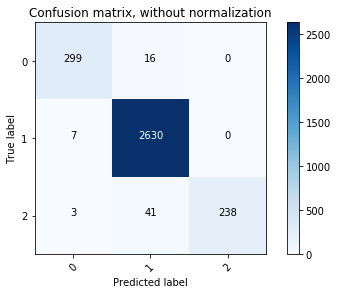

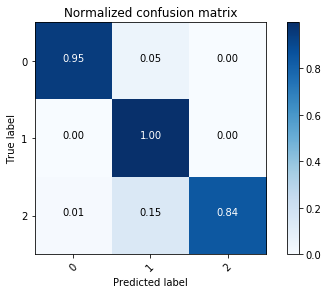

Confusion matrix, without normalization
[[ 27   5   4]
 [  9 284   1]
 [  4   9  19]]
Normalized confusion matrix
[[0.75       0.13888889 0.11111111]
 [0.03061224 0.96598639 0.00340136]
 [0.125      0.28125    0.59375   ]]


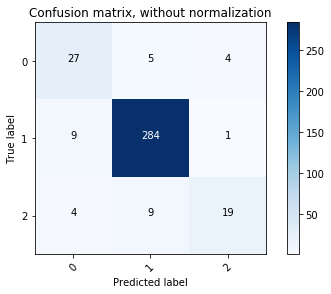

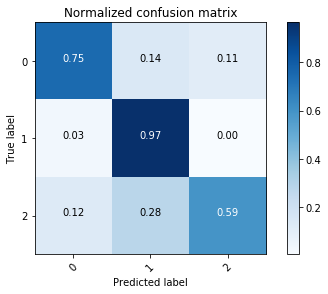

Wall time: 14min 47s


In [23]:
%%time
X_ct_train, y_ct_train, X_ct_test, y_ct_test = divide_to_train_end_test(X_ct_FNS128, y_ct_FNS128, num_categories=3)


model_ct, history_ct, test_scores_ct = run_VGG16_without_retrain_on_dataset(X_ct_train, y_ct_train,
                                                                           X_ct_test, y_ct_test,
                                                                           categories_count=3,
                                                                           patience=10)

In [26]:
print("center result accuracy:", test_scores_ct[1])

center result accuracy: 0.9116022102740589


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 24579     
Total params: 14,739,267
Trainable params: 24,579
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 3234 samples, validate on 362 samples
Epoch 1/300
3234/3234 [==============================] - 19s 6ms/step - loss: 1.8616 - acc: 0.8649 - val_loss: 1.3729 - val_acc: 0.9116
Epoch 2/300
3234/3234 [==============================] - 17s 5ms/step

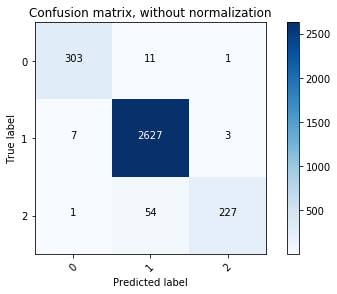

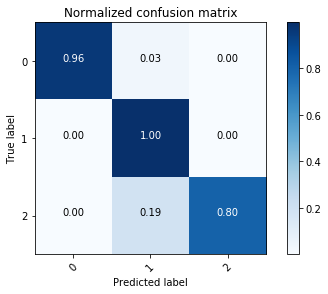

Confusion matrix, without normalization
[[ 28   8   0]
 [  6 288   0]
 [  3   9  20]]
Normalized confusion matrix
[[0.77777778 0.22222222 0.        ]
 [0.02040816 0.97959184 0.        ]
 [0.09375    0.28125    0.625     ]]


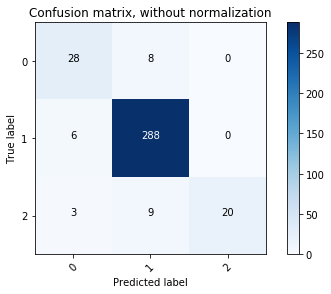

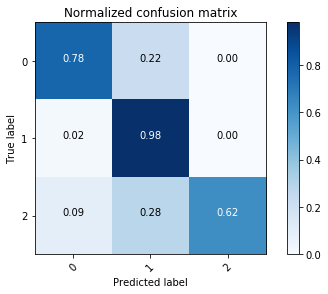

Wall time: 4min 45s


In [27]:
%%time
X_lt_train, y_lt_train, X_lt_test, y_lt_test = divide_to_train_end_test(X_lt_FNS128, y_lt_FNS128, num_categories=3)


model_lt, history_lt, test_scores_lt = run_VGG16_without_retrain_on_dataset(X_lt_train, y_lt_train,
                                                                           X_lt_test, y_lt_test,
                                                                           categories_count=3,
                                                                           patience=7)

In [28]:
print("left_top result accuracy:", test_scores_lt[1])

left_top result accuracy: 0.9281767952508031


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_10 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 24579     
Total params: 14,739,267
Trainable params: 24,579
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 3234 samples, validate on 362 samples
Epoch 1/300
3234/3234 [==============================] - 19s 6ms/step - loss: 1.8959 - acc: 0.8609 - val_loss: 1.2796 - val_acc: 0.8978
Epoch 2/300
3234/3234 [==============================] - 18s 6ms/step

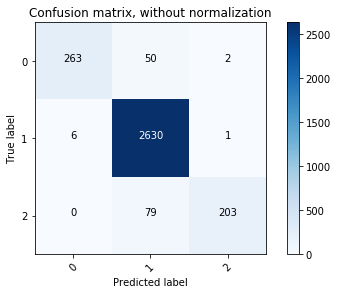

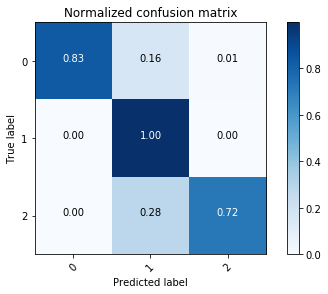

Confusion matrix, without normalization
[[ 23  10   3]
 [  3 291   0]
 [  0  18  14]]
Normalized confusion matrix
[[0.63888889 0.27777778 0.08333333]
 [0.01020408 0.98979592 0.        ]
 [0.         0.5625     0.4375    ]]


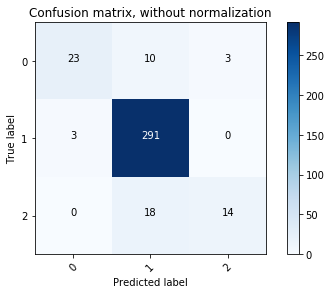

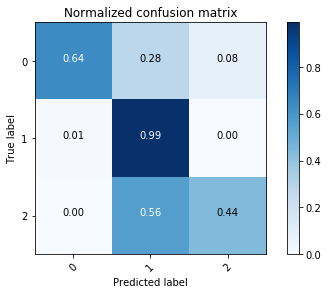

Wall time: 2min 40s


In [29]:
%%time
X_rt_train, y_rt_train, X_rt_test, y_rt_test = divide_to_train_end_test(X_rt_FNS128, y_rt_FNS128, num_categories=3)


model_rt, history_rt, test_scores_rt = run_VGG16_without_retrain_on_dataset(X_rt_train, y_rt_train,
                                                                           X_rt_test, y_rt_test,
                                                                           categories_count=3,
                                                                           patience=7)

In [31]:
print("right_top result accuracy:", test_scores_rt[1])

right_top result accuracy: 0.9060773487249132


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 24579     
Total params: 14,739,267
Trainable params: 24,579
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 3234 samples, validate on 362 samples
Epoch 1/300
3234/3234 [==============================] - 19s 6ms/step - loss: 1.8101 - acc: 0.8723 - val_loss: 1.3500 - val_acc: 0.9033
Epoch 2/300
3234/3234 [==============================] - 18s 6ms/step

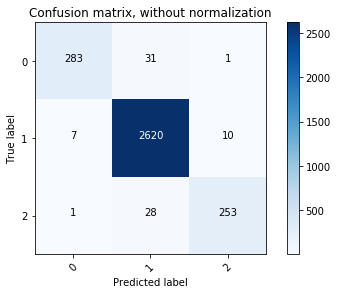

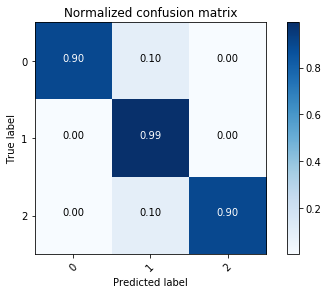

Confusion matrix, without normalization
[[ 22  10   4]
 [  0 288   6]
 [  1   6  25]]
Normalized confusion matrix
[[0.61111111 0.27777778 0.11111111]
 [0.         0.97959184 0.02040816]
 [0.03125    0.1875     0.78125   ]]


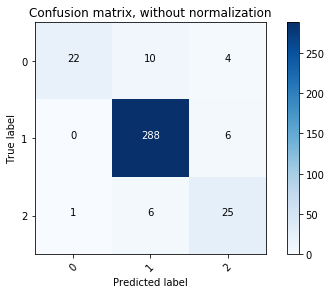

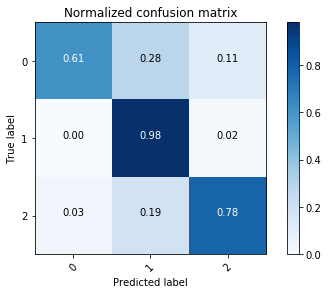

Wall time: 4min 43s


In [32]:
%%time
X_lb_train, y_lb_train, X_lb_test, y_lb_test = divide_to_train_end_test(X_lb_FNS128, y_lb_FNS128, num_categories=3)


model_lb, history_lb, test_scores_lb = run_VGG16_without_retrain_on_dataset(X_lb_train, y_lb_train,
                                                                           X_lb_test, y_lb_test,
                                                                           categories_count=3,
                                                                           patience=7)

In [33]:
print("left_bottom result accuracy:", test_scores_lb[1])

left_bottom result accuracy: 0.925414364640884


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 24579     
Total params: 14,739,267
Trainable params: 24,579
Non-trainable params: 14,714,688
_________________________________________________________________
None
Train on 3234 samples, validate on 362 samples
Epoch 1/300
3234/3234 [==============================] - 19s 6ms/step - loss: 3.0392 - acc: 0.8092 - val_loss: 3.0277 - val_acc: 0.8122
Epoch 2/300
3234/3234 [==============================] - 17s 5ms/step

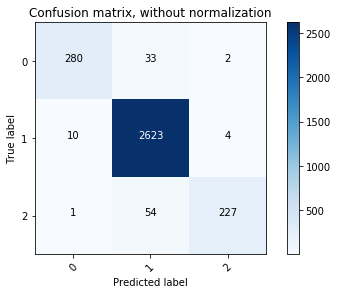

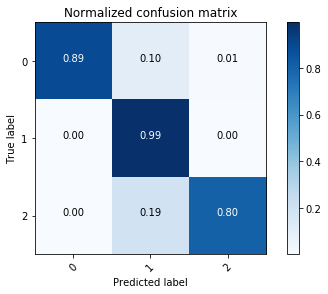

Confusion matrix, without normalization
[[ 25   5   6]
 [  1 291   2]
 [  1  10  21]]
Normalized confusion matrix
[[0.69444444 0.13888889 0.16666667]
 [0.00340136 0.98979592 0.00680272]
 [0.03125    0.3125     0.65625   ]]


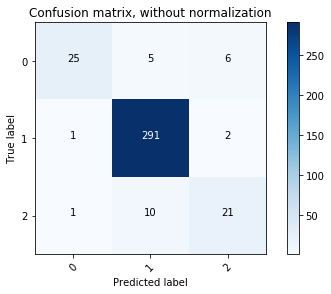

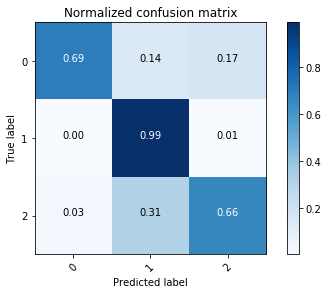

Wall time: 5min 33s


In [34]:
%%time
X_rb_train, y_rb_train, X_rb_test, y_rb_test = divide_to_train_end_test(X_rb_FNS128, y_rb_FNS128, num_categories=3)


model_rb, history_rb, test_scores_rb = run_VGG16_without_retrain_on_dataset(X_rb_train, y_rb_train,
                                                                           X_rb_test, y_rb_test,
                                                                           categories_count=3,
                                                                           patience=7)

In [35]:
print("right_bottom result accuracy:", test_scores_rb[1])

right_bottom result accuracy: 0.9309392258607222


## Validation accuracy results

In [43]:
print("center result accuracy: %.4f" % test_scores_ct[1])
print("left_top result accuracy: %.4f" % test_scores_lt[1])
print("right_top result accuracy: %.4f" % test_scores_rt[1])
print("left_bottom result accuracy: %.4f" % test_scores_lb[1])
print("right_bottom result accuracy: %.4f" % test_scores_rb[1])

center result accuracy: 0.9116
left_top result accuracy: 0.9282
right_top result accuracy: 0.9061
left_bottom result accuracy: 0.9254
right_bottom result accuracy: 0.9309


In [49]:
predict_result_ct_train = model_ct.predict(X_ct_train)
predict_result_ct_test = model_ct.predict(X_ct_test)

predict_result_lt_train = model_lt.predict(X_lt_train)
predict_result_lt_test = model_lt.predict(X_lt_test)

predict_result_rt_train = model_lt.predict(X_rt_train)
predict_result_rt_test = model_lt.predict(X_rt_test)

predict_result_lb_train = model_lt.predict(X_lb_train)
predict_result_lb_test = model_lt.predict(X_lb_test)

predict_result_rb_train = model_lt.predict(X_rb_train)
predict_result_rb_test = model_lt.predict(X_rb_test)

In [53]:
predict_un_train = np.concatenate((predict_result_ct_train,
                                  predict_result_lt_train,
                                  predict_result_rt_train,
                                  predict_result_lb_train,
                                  predict_result_rb_train), axis=1)
print(predict_un_train.shape)

(3234, 15)


In [54]:
predict_un_test = np.concatenate((predict_result_ct_test,
                                  predict_result_lt_test,
                                  predict_result_rt_test,
                                  predict_result_lb_test,
                                  predict_result_rb_test), axis=1)
print(predict_un_test.shape)

(362, 15)


In [60]:
# than write this arrays into file
file_path_un_train = "./un_train_France_ByShape128.npy"
np.save(file_path_un_train, predict_un_train)

file_path_un_test = "./un_test_France_ByShape128.npy"
np.save(file_path_un_test, predict_un_test)

file_path_y_train = "./y_train_France_ByShape128.npy"
np.save(file_path_y_train, y_ct_train)

file_path_y_test = "./y_test_France_ByShape128.npy"
np.save(file_path_y_test, y_ct_test)

In [59]:
#np.load(file_path_un_train)

test accuracy:  0.9309

Confusion matrix, without normalization
[[ 302   12    1]
 [   8 2626    3]
 [   2   28  252]]
Normalized confusion matrix
[[0.95873016 0.03809524 0.0031746 ]
 [0.00303375 0.99582859 0.00113766]
 [0.0070922  0.09929078 0.89361702]]


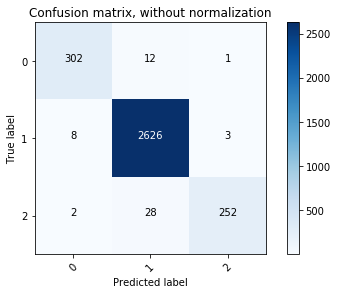

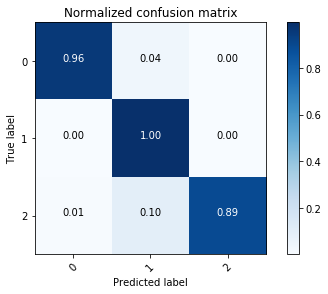

Confusion matrix, without normalization
[[ 29   5   2]
 [  7 287   0]
 [  4   7  21]]
Normalized confusion matrix
[[0.80555556 0.13888889 0.05555556]
 [0.02380952 0.97619048 0.        ]
 [0.125      0.21875    0.65625   ]]


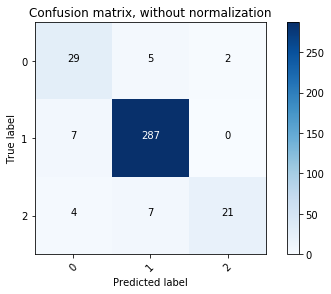

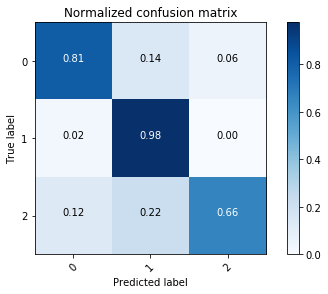

In [80]:
#let's try KNN first
categories_count = 3

knn_uniform_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='uniform')
knn_uniform_15.fit(predict_un_train, one_hot(y_ct_train, categories_count))

acc_knn_uniform_15 = accuracy_score(one_hot(y_ct_test, categories_count), knn_uniform_15.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_knn_uniform_15)
print("")

print_confusion_matrix(knn_uniform_15, predict_un_train, y_ct_train, 
                       predict_un_test, y_ct_test, categories_count=categories_count)

test accuracy:  0.9337

Confusion matrix, without normalization
[[ 314    1    0]
 [   0 2637    0]
 [   0    6  276]]
Normalized confusion matrix
[[0.9968254 0.0031746 0.       ]
 [0.        1.        0.       ]
 [0.        0.0212766 0.9787234]]


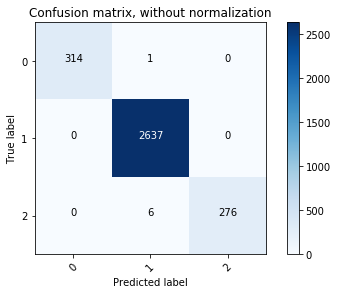

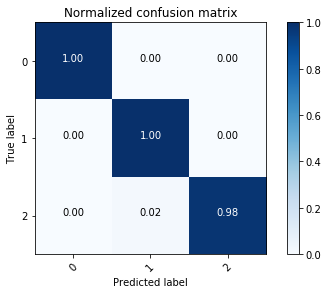

Confusion matrix, without normalization
[[ 29   5   2]
 [  6 288   0]
 [  4   7  21]]
Normalized confusion matrix
[[0.80555556 0.13888889 0.05555556]
 [0.02040816 0.97959184 0.        ]
 [0.125      0.21875    0.65625   ]]


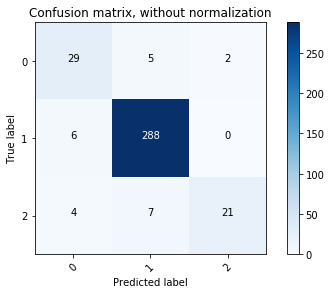

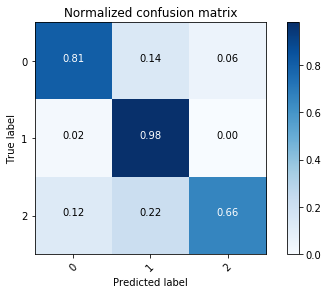

In [83]:
#let's try KNN with another weights
categories_count = 3

knn_distance_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='distance')
knn_distance_15.fit(predict_un_train, one_hot(y_ct_train, categories_count))

acc_knn_distance_15 = accuracy_score(one_hot(y_ct_test, categories_count), knn_distance_15.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_knn_distance_15)
print("")

print_confusion_matrix(knn_distance_15, predict_un_train, y_ct_train, 
                       predict_un_test, y_ct_test, categories_count=categories_count)

In [88]:
# than SVM
svm = SVC(kernel='rbf')
svm.fit(predict_un_train, y_ct_train)

acc_svm = accuracy_score(y_ct_test, svm.predict(predict_un_test))
print("test accuracy:  %.4f" % acc_svm)
print("")

#print_confusion_matrix(svm, predict_un_train, y_ct_train, 
#                       predict_un_test, y_ct_test, categories_count=categories_count)

test accuracy:  0.9282



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 512)               8192      
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 771       
Total params: 140,291
Trainable params: 140,291
Non-trainable params: 0
_________________________________________________________________
None
Train on 3234 samples, validate on 362 samples
Epoch 1/300
3234/3234 [==============================] - 14s 4ms/step - loss: 0.0999

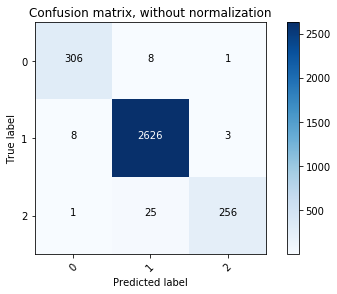

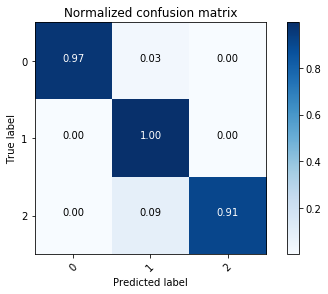

Confusion matrix, without normalization
[[ 27   5   4]
 [  6 287   1]
 [  3   7  22]]
Normalized confusion matrix
[[0.75       0.13888889 0.11111111]
 [0.02040816 0.97619048 0.00340136]
 [0.09375    0.21875    0.6875    ]]


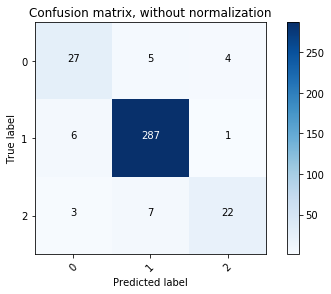

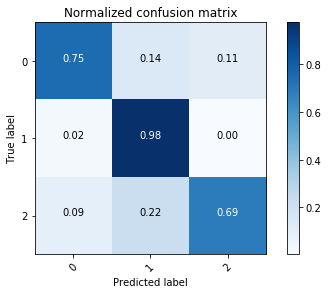

Wall time: 2min 29s


In [91]:
%%time
# and also multilayer neuron net
categories_count = 3

meta_net = Sequential()
meta_net.add(Dense(512, input_shape=predict_un_train[0].shape))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(256))
meta_net.add(Dropout(0.5))
meta_net.add(Dense(categories_count, activation='softmax'))
meta_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(meta_net.summary())
    
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history_callback = meta_net.fit(predict_un_train, one_hot(y_ct_train, categories_count), 
                            validation_data=(predict_un_test, one_hot(y_ct_test, categories_count)),
                            epochs=300, batch_size=10, callbacks=[callback])

test_scores = meta_net.evaluate(predict_un_test, one_hot(y_ct_test, categories_count), verbose=0)
    
print_confusion_matrix(meta_net, predict_un_train, y_ct_train, predict_un_test, y_ct_test, categories_count)

In [94]:
print("test accuracy:  %.4f" % test_scores[1])
print("best test accuracy: %.4f" % max(history_callback.history['val_acc']))

test accuracy:  0.9282
best test accuracy: 0.9365
